
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


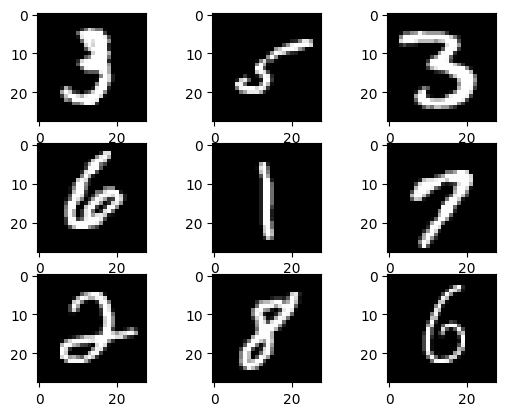

Test Accuracy : 97.750
Training deltaT =  69.09404329999234  sec


Test Accuracy : 97.783
Training deltaT =  133.8527907000098  sec


Test Accuracy : 97.517
Training deltaT =  198.73966160000418  sec


Test Accuracy : 98.267
Training deltaT =  270.840632300009  sec
Test Accuracy : 98.050
Training deltaT =  345.34838680000394  sec


C:\Users\ffah\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


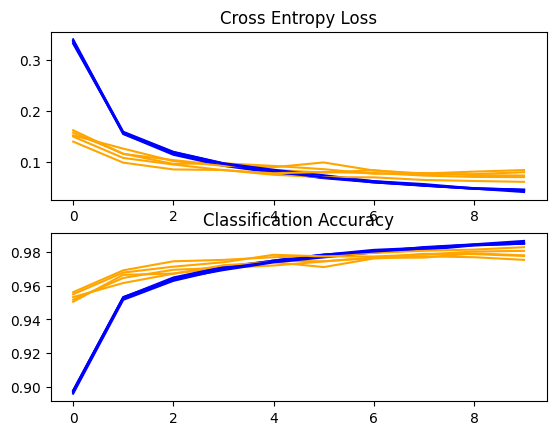

Accuracy: mean=97.873 std=0.259, n=5


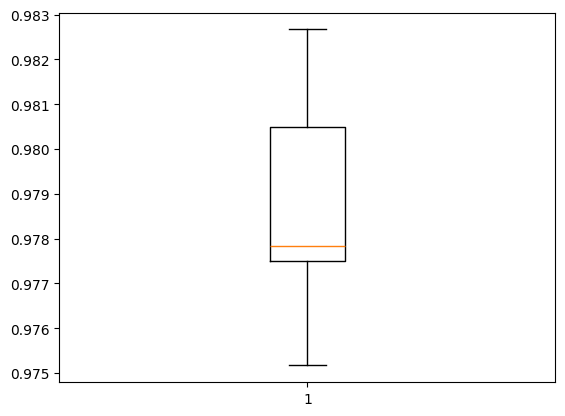

In [1]:
from numpy import mean, std
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from timeit import default_timer as timer
import joblib

# Part 1: load MNIST dataset of Handwritten numbers -----------------
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first 9 images of Handwritten numbers
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i+10], cmap=plt.get_cmap('gray'))
# display the figure
plt.show()

# Part 2: load train and test dataset ------------------------------
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel of dimension 28x28
    trainX = trainX.reshape(trainX.shape[0], 784)
    testX = testX.reshape(testX.shape[0], 784)
    # "to_categorial" method of Numpy utilities to perform encoding
    # using one-hot encoding for 10 target numbers
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY
 
# Part 3: scale pixels to a range [0,1] ----------------------------
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm
 
# Part 3.5: Computer principal component analysis ------------------------------------------------
def PCA_project(trainX_norm, trainy, n=0.9):
    # Projecting the original data into n-Dimension principal components 
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(trainX_norm)
    joblib.dump(pca, "PCA_model.pkl") # Save PCA-model in current working directory
    n_comp = len(principalComponents[1])
    print("Number of PCA = ", n_comp)
    print(pca.explained_variance_ratio_)
    
    plt.figure(1)
    plt.xticks(fontsize=12), plt.yticks(fontsize=12)
    plt.xlabel('Principal Component - 1',fontsize=12)
    plt.ylabel('Principal Component - 2',fontsize=12)
    plt.title("Principal Component Analysis of MNIST Dataset", fontsize=12)
    targets = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    colors = ['r', 'g', 'b', 'y', 'k', 'm', 'c', 'r', 'g', 'b']
    markers = ["^","o","p","x","s","*","+","d","<","h"]
    for target, color, m in zip(targets, colors, markers):
        indicesToKeep = np.where(trainy == target)
        plt.scatter(principalComponents[indicesToKeep][0]
                   ,principalComponents[indicesToKeep][1]
                   , marker = m, c = color, s = 50)

    plt.legend(targets,prop={'size': 15})
    plt.xlim([-7,7]), plt.ylim([-7,7])
    plt.show()
    
    return principalComponents, n_comp 
 
# Part 4: define Deep Neural Network (DNN) model -----------------------------------------------------
def define_model(n_PCA):
    model = Sequential()
    # Add an input layer: dimensionality of the input = 784 pixels
    model.add(Dense(256, activation='relu', input_shape=(n_PCA,), kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    # Add one Hidden layer: output of this layer is arrays of shape = 512 hidden nodes
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    # Add an output layer: ending network with a Dense layer of size 3.
    model.add(Dense(10, activation='softmax'))
    # compile the DNN network
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 
    return model
 
# Part 5: evaluate a model using k-fold cross-validation ---------------------------------------------
def evaluate_model(dataX, dataY, n_PCA, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    Tstart = timer()
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model(n_PCA)
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('Test Accuracy : %.3f' % (acc * 100.0))
        scores.append(acc), histories.append(history) # stores scores
        Tend = timer(); deltaT = Tend - Tstart
        print('Training deltaT = ',deltaT,' sec')
    model.save('finalPCA_model.h5') # save Deep neural network (DNN) model
    return scores, histories
 
# Part 6: plot diagnostic learning curves ----------------------------------------------------------
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        plt.subplot(2, 1, 1) # plot loss
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        plt.subplot(2, 1, 2) # plot accuracy
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()
    
# Part 7: summarize model performance --------------------------------------------------------------
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()
    
# Part 8: Main Program - run the test harness for evaluating a model  ------------------------------
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    n_PCA = 784 # in case of using original data
    # compute PC from original data
    #trainX, n_PCA = PCA_project(trainX, trainy)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY, n_PCA)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)
 
# run the test harness for Main Program
run_test_harness()